##### Colab-specific section (convert to code if needed)
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!unlink "/content/coopmotion"
!ln -s "/gdrive/My Drive/coopmotion/" "/content/coopmotion"
!rm -r "/content/coopmotion/dataset (1)" "/content/coopmotion/dataset" "/content/coopmotion/models"

In [ ]:
!rm -r "/content/coopmotion/notebook/videos"

In [ ]:
#!mv -r "/content/videos" "/content/coopmotion/notebook/videos"
!mv "/content/videos" "/content/coopmotion/notebook/videos"

In [77]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
sys.path.append('coopmotion/src') # COLAB
from matplotlib import pyplot as plt
import numpy as np
import torch
import time

from IPython.display import Audio
sound_file = './sound.wav'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Learning

In [78]:
from task.square import SquareRun, proportional, sense, static_shape_task
controller = proportional
shape=3
N=21
sas, tas = 1, 1

In [79]:
#from task.fancy import animate_trace
#trace = run()
#animate_trace(trace, dt=0.05)

In [80]:
number_of_samples = 10000
valid_part = 0.2
keep = 0.1

# Centralized Network

In [81]:
task = static_shape_task(shape=shape, N=N, holonomic=True, spawn_area_size=sas, target_area_size=tas)
run = SquareRun(task, controller=controller, sensor=sense(), dt=0.1)

In [82]:
from task.dataset import generate_non_sequential_dataset, central_dataset
train_nseq = generate_non_sequential_dataset(run=run, number=number_of_samples, keep=keep, seed=0xDEADBEEF)
train_dataset, valid_dataset = central_dataset(train_nseq, valid_part)

train: x (8000, 42)	y (8000, 42)
valid: x (2001, 42)	y (2001, 42)


In [83]:
from keras_network import CentralizedNet
net = CentralizedNet(N, run.task.holonomic, patience=40)
history = net.train(epochs=200, train_dataset=train_dataset, valid_dataset=valid_dataset)

Train on 8000 samples, validate on 2001 samples
Epoch 1/200
8000/8000 [==============================] - 0s 61us/sample - loss: 0.0085 - mean_absolute_error: 0.0655 - val_loss: 0.0025 - val_mean_absolute_error: 0.0354
Epoch 2/200
8000/8000 [==============================] - 0s 33us/sample - loss: 0.0016 - mean_absolute_error: 0.0292 - val_loss: 8.3686e-04 - val_mean_absolute_error: 0.0206
Epoch 3/200
8000/8000 [==============================] - 0s 34us/sample - loss: 7.9483e-04 - mean_absolute_error: 0.0211 - val_loss: 8.4375e-04 - val_mean_absolute_error: 0.0222
Epoch 4/200
8000/8000 [==============================] - 0s 38us/sample - loss: 7.0288e-04 - mean_absolute_error: 0.0198 - val_loss: 5.6652e-04 - val_mean_absolute_error: 0.0167
Epoch 5/200
8000/8000 [==============================] - 0s 35us/sample - loss: 6.5323e-04 - mean_absolute_error: 0.0189 - val_loss: 9.0046e-04 - val_mean_absolute_error: 0.0237
Epoch 6/200
8000/8000 [==============================] - 0s 34us/sample - 

Epoch 92/200
8000/8000 [==============================] - 0s 31us/sample - loss: 2.0132e-04 - mean_absolute_error: 0.0106 - val_loss: 2.1406e-04 - val_mean_absolute_error: 0.0113
Epoch 93/200
8000/8000 [==============================] - 0s 33us/sample - loss: 1.9995e-04 - mean_absolute_error: 0.0107 - val_loss: 9.6248e-05 - val_mean_absolute_error: 0.0070
Epoch 94/200
8000/8000 [==============================] - 0s 31us/sample - loss: 1.9685e-04 - mean_absolute_error: 0.0106 - val_loss: 1.7171e-04 - val_mean_absolute_error: 0.0100
Epoch 95/200
8000/8000 [==============================] - 0s 33us/sample - loss: 1.9709e-04 - mean_absolute_error: 0.0106 - val_loss: 1.7521e-04 - val_mean_absolute_error: 0.0102
Epoch 96/200
8000/8000 [==============================] - 0s 33us/sample - loss: 1.9390e-04 - mean_absolute_error: 0.0105 - val_loss: 2.0637e-04 - val_mean_absolute_error: 0.0107
Epoch 97/200
8000/8000 [==============================] - 0s 33us/sample - loss: 1.9356e-04 - mean_absolu

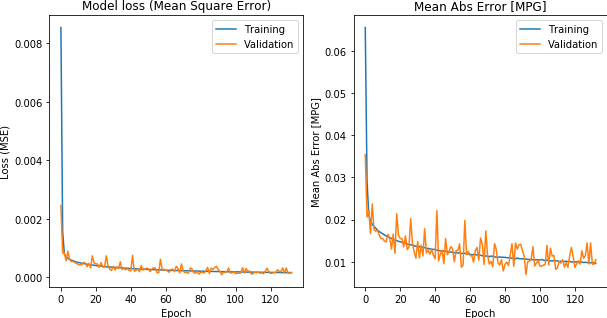

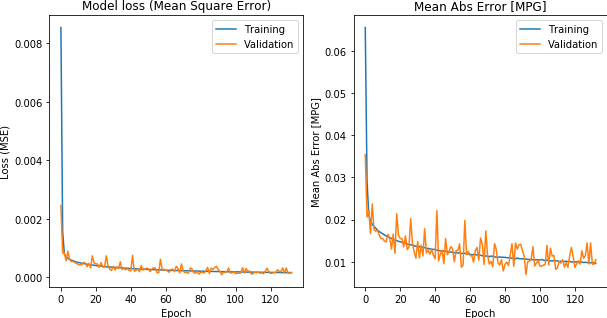

In [84]:
from task.fancy import training_plot
training_plot(history)

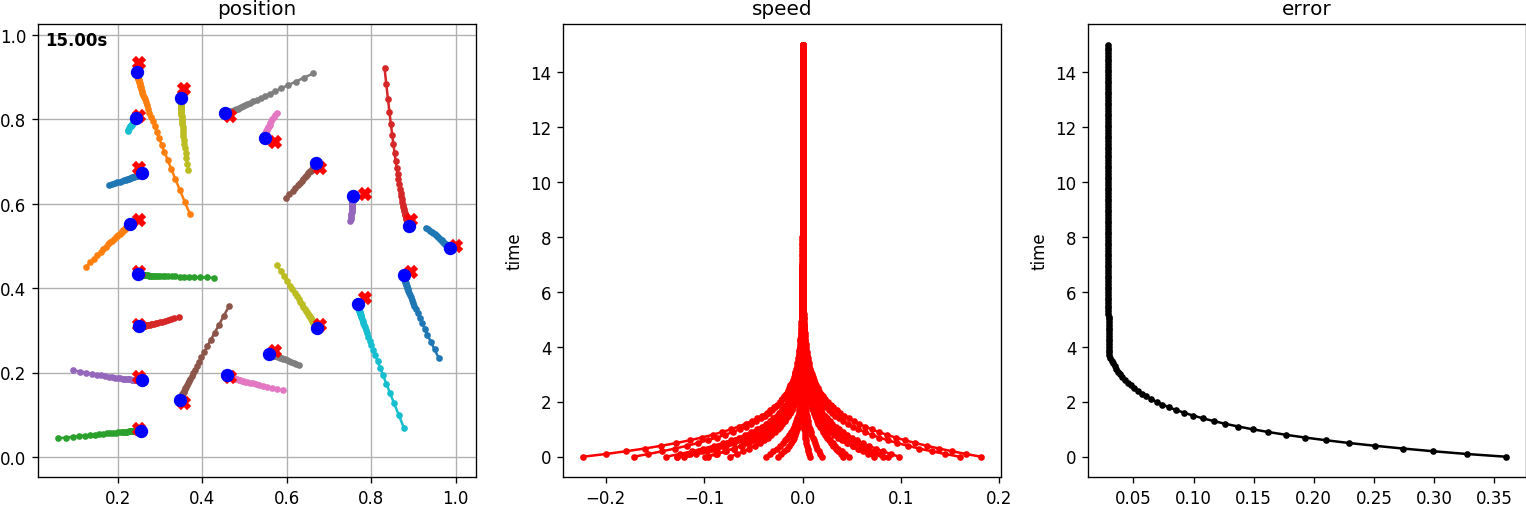

In [85]:
from task import Run
from task.fancy import plot_trace
net_controller = net.controller()
net_run = Run(task, sensor=run.sensor, dt=0.1, controller=net_controller)
c_trace = net_run(T=15, epsilon=0.01, seed=0xDEADBEEF)
plot_trace(c_trace, task)

In [86]:
from task.fancy import TracesAnimator
expert_trace = run(T=10, epsilon=0.01, seed=0xDEADBEEF)
TracesAnimator({'expert':expert_trace,'centralized': c_trace}, dt=0.05)

### How well are we controlling the agents?

In [87]:
from task.dataset import generate_sequential_dataset
comp_run, comp_duration, comp_steps = 100, 10, 50
exact_traces = generate_sequential_dataset(run, number=comp_run, duration=comp_duration, epsilon=0.01)
net_traces = generate_sequential_dataset(net_run, number=comp_run, duration=comp_duration, epsilon=0.01)
from task import prepare
exact_traces = [prepare(t, padding=True, steps=comp_steps) for t in exact_traces]
net_traces = [prepare(t, padding=True, steps=comp_steps) for t in net_traces]
time = exact_traces[0].time
exact_error = np.array([t.error for t in exact_traces])
net_error = np.array([t.error for t in net_traces])

Undefined 'steps': assuming 'number' specifies the number of runs (instead of desired samples)


Undefined 'steps': assuming 'number' specifies the number of runs (instead of desired samples)


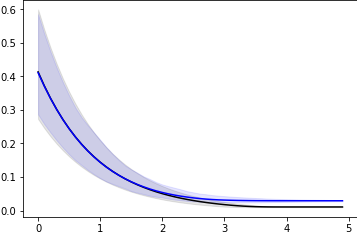

In [88]:
from task.fancy import plot_error
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')

## Distributed Network

In [91]:
from task.square import adaptive_shape_task
task = adaptive_shape_task(shape=shape,N=N, holonomic=True, spawn_area_size=sas, target_area_size=tas)
run = SquareRun(task, controller=controller, sensor=sense(), dt=0.1)

In [92]:
number_of_samples = 1000
train_nseq = generate_non_sequential_dataset(run=run, number=number_of_samples, keep=keep)
from task.dataset import distributed_dataset
d_train_dataset, d_valid_dataset = distributed_dataset(train_nseq, valid_part)

x (168033, 40)	y (168033, 2)


### Alternative training

40


x (168033, 40)	y (168033, 2)
Train on 168033 samples, validate on 42009 samples
168033/168033 [==============================] - 7s 39us/sample - loss: 0.0045 - mean_absolute_error: 0.0429 - val_loss: 0.0036 - val_mean_absolute_error: 0.0400


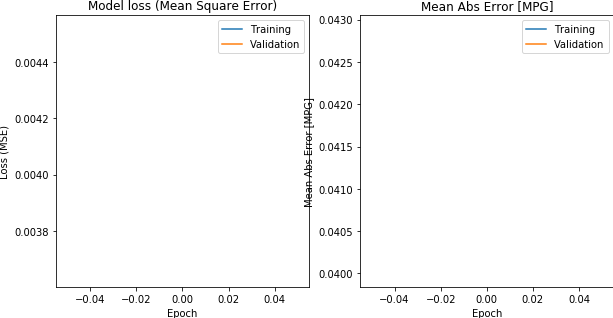

x (168033, 40)	y (168033, 2)
Train on 168033 samples, validate on 42009 samples
168033/168033 [==============================] - 6s 33us/sample - loss: 0.0032 - mean_absolute_error: 0.0352 - val_loss: 0.0033 - val_mean_absolute_error: 0.0370


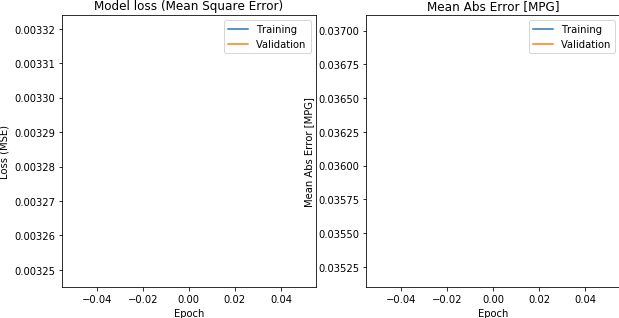

x (168050, 40)	y (168050, 2)
Train on 168050 samples, validate on 42013 samples
168050/168050 [==============================] - 7s 40us/sample - loss: 0.0030 - mean_absolute_error: 0.0337 - val_loss: 0.0030 - val_mean_absolute_error: 0.0335


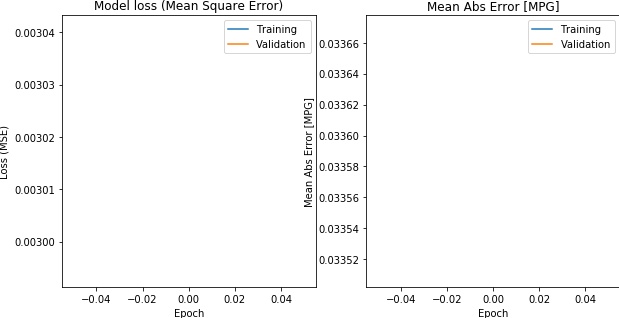

x (168067, 40)	y (168067, 2)
Train on 168067 samples, validate on 42017 samples
168067/168067 [==============================] - 6s 38us/sample - loss: 0.0030 - mean_absolute_error: 0.0329 - val_loss: 0.0032 - val_mean_absolute_error: 0.0356


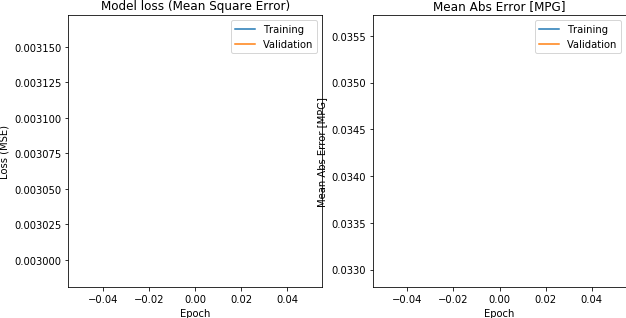

KeyboardInterrupt: 

In [99]:
from keras_network import DistributedNet
d_net = DistributedNet(run=run, patience=40)
number_of_samples = 10000
for _ in range(100):
    train_nseq = generate_non_sequential_dataset(run=run, number=number_of_samples, keep=keep)
    d_train_dataset, d_valid_dataset = distributed_dataset(train_nseq, valid_part)
    history = d_net.train(epochs=1, train_dataset=d_train_dataset, valid_dataset=d_valid_dataset)
    training_plot(history)
Audio(sound_file, autoplay=True)

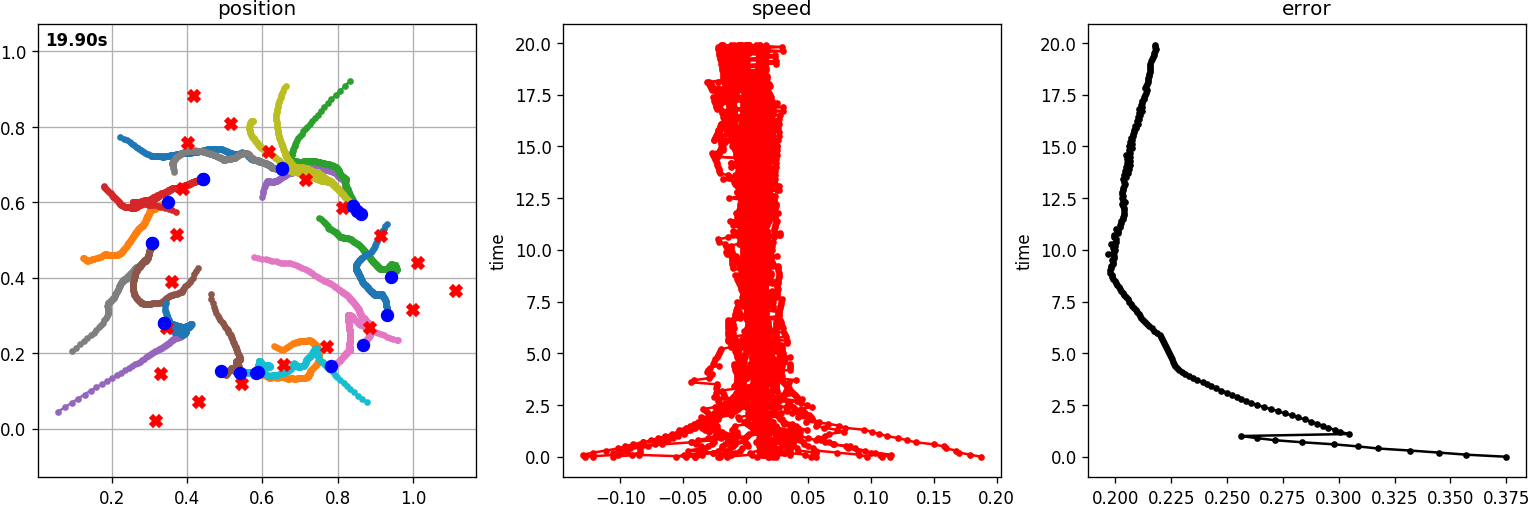

In [100]:
d_net_controller = d_net.controller()
d_net_run = Run(task, sensor=run.sensor, dt=0.1, controller=d_net_controller)
d_trace = d_net_run(T=20, epsilon=0.01, seed=0xDEADBEEF)
plot_trace(d_trace, task)
expert_trace = run(T=15, epsilon=0.01, seed=0xDEADBEEF)
TracesAnimator({'expert':expert_trace,'centralized': c_trace, 'distributed': d_trace}, dt=0.05)

In [95]:
d_net_traces = generate_sequential_dataset(d_net_run, number=100, duration=10, epsilon=0.01)
d_net_traces = [prepare(t, padding=True, steps=50) for t in d_net_traces]
d_net_error = np.array([t.error for t in d_net_traces])

Undefined 'steps': assuming 'number' specifies the number of runs (instead of desired samples)


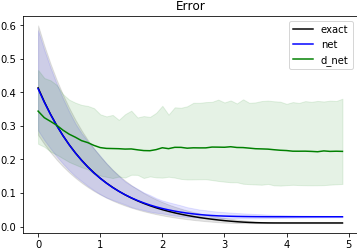

In [96]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plt.legend()
plt.title('Error');

## Distributed Communicating Network

### Standard training

In [103]:
from task.square import SquareRun, adaptive_zipf_task
task = adaptive_zipf_task(N, spawn_area_size=sas, target_area_size=tas, holonomic=True)
run = SquareRun(task, controller=controller, sensor=sense(robot_range=10), dt=0.1)

In [104]:
steps = 5
number_of_samples = 10000
train_traces = generate_sequential_dataset(run=run, number=number_of_samples, steps=steps, keep=keep)
test_traces = generate_sequential_dataset(run=run, number=number_of_samples, steps=steps, keep=keep)
from task.dataset import sequence_dataset
cd_train_dataset = sequence_dataset(train_traces)
cd_test_dataset  = sequence_dataset(test_traces)
list(np.unique([x[0].shape[0] for x in cd_train_dataset]))

[5]

In [105]:
from com_network import ComNet
from pytorch_network import train_net
cd_net = ComNet(N=N, broadcast=5)
cd_training_loss, cd_testing_loss = [], []
train_net(epochs=10, net=cd_net, train_dataset=cd_train_dataset, test_dataset=cd_test_dataset, batch_size=1, 
          training_loss=cd_training_loss, testing_loss=cd_testing_loss, disable_tqdm=False)

100%|██████████| 10/10 [1:30:47<00:00, 538.65s/it]


([204.73007102357224,
  175.67580499872565,
  142.1059005013667,
  130.28035357315093,
  123.55347928963602,
  120.19582252390683,
  118.35946678416803,
  116.87875583628193,
  115.35684655234218,
  114.37856506789103],
 [203.00459976494312,
  160.64989089756273,
  131.78456489369273,
  135.97850571060553,
  126.45441966084763,
  121.5365922562778,
  118.73053868766874,
  130.31973131652921,
  124.87119327578694,
  120.81692013889551])

### Distributed Communicating - Dagger Training

In [74]:
from com_network import ComNet
from pytorch_network import train_net
cd_net = ComNet(N=N, broadcast=2)
cd_training_loss, cd_testing_loss = [], []

In [ ]:
average_expert_iterations = np.mean([len(run().time) for _ in range(10)]).astype(int)
safe_limsup = int(average_expert_iterations*1.5)

from task.math import dagger_remappers
steps = 3
x, y = dagger_remappers(100, safe_limsup, steps, x_dilation = 3, y_dilation=1)

plt.scatter(x,y, color='r')
plt.scatter(x,safe_limsup-y, color='b')
len(y)
print(y, safe_limsup-y)

In [75]:
from IPython.display import display, clear_output
from task.square import DaggerSquareRun
from task.fancy import pytorch_dagger_plot
#import matplotlib.pyplot as plt
steps = 3
keep = 0.2
epochs = 100
samples_per_epoch = 1000
#_, net_ws = dagger_remappers(epochs, safe_limsup, 0)
#exp_ws = safe_limsup - net_ws
net_ws = [20] * epochs
exp_ws = [30] * epochs
for e in range(epochs):
    print(f"Epoch {e}")
    dagger_run = DaggerSquareRun(cd_net, task, controller, run.sensor, 
                                 expert_window=exp_ws[e], net_window=net_ws[e])
    
    train_test = [generate_sequential_dataset(run=dagger_run, number=samples_per_epoch, disable_tqdm=True,
                                               steps=steps, keep=keep, duration=5) for _ in range(2)]
    cd_train_dataset, cd_test_dataset = [sequence_dataset(raw_data) for raw_data in train_test]
    
    train_net(epochs=10, net=cd_net, train_dataset=cd_train_dataset, test_dataset=cd_test_dataset, batch_size=1, 
          training_loss=cd_training_loss, testing_loss=cd_testing_loss, disable_tqdm=True)
    
    fig = pytorch_dagger_plot(cd_training_loss, cd_testing_loss, net_ws[:e], exp_ws[:e])
    
    display(fig)
    clear_output(wait = True)
    plt.pause(0.5)
#expert_dagger_trace = dagger_run(T=22, seed=0xDEADBEEF)
#plot_trace(expert_dagger_trace,task)

Epoch 0


RuntimeError: size mismatch, m1: [1 x 80], m2: [100 x 64] at ../aten/src/TH/generic/THTensorMath.cpp:961

In [ ]:
fig = pytorch_dagger_plot(cd_training_loss, cd_testing_loss, net_ws, exp_ws)

## Distributed Communicating Network - Testing

In [ ]:
cd_net_controller = cd_net.controller()
cd_net_run = Run(task, sensor=run.sensor, dt=0.1, controller=cd_net_controller)
cd_trace = cd_net_run(T=15, seed=0xDEADBEEF)
expert_trace = run(T=15, seed=0xDEADBEEF)
plot_trace(cd_trace,task)

In [ ]:
# animate_trace(trace, robot_range=20, dt= 0.05)
traces_dict = {'expert':expert_trace,'centralized (static)': c_trace, 
               'distributed': d_trace, 'distributed (comm)': cd_trace}
TracesAnimator(traces_dict, robot_range=10, dt=0.05)

In [ ]:
fig = plt.figure(figsize=(9, 5), dpi=120)
plt.plot(cd_trace.control[:,:,0], cd_trace.communication[:,0,:], '.');
plt.title('Communication buffer');

In [ ]:
cd_net_traces = generate_sequential_dataset(cd_net_run, number=100, duration=5, epsilon=0.01)
cd_net_traces = [prepare(t, padding=True, steps=50) for t in cd_net_traces]
cd_net_error = np.array([t.error for t in cd_net_traces])

In [ ]:
fig = plt.figure(figsize=(9, 5), dpi=150)
plot_error(time, exact_error, color='black', label='expert')
plot_error(time, net_error, color='blue', label='centralized')
plot_error(time, d_net_error, color='green', label='distributed')
plot_error(time, cd_net_error, color='orange', label='distributed (comm)')
plt.legend()
plt.title('Error');